## Import necessary modules and check GPU devices

In [1]:
import os
import time
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms as T
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
%pwd

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/yw5281/code/Users/yw528/CV_Project1'

In [3]:
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: ", device)

torch:  1.10 ; cuda:  cu102
device:  cuda:0


## Pre-processing

### Load and transform the dataset

In [4]:
# Define the transforms to be applied to the images

# Reference: https://github.com/AIPI540/AIPI540-Deep-Learning-Applications/blob/main/2_computer_vision/CNNs/transfer_learning.ipynb

transform_train = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.RandomRotation(degrees=30),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), 
                std=(0.229, 0.224, 0.225)), # normalize the pixel values according to the mean and std of ImageNet
])

transform_val_test = T.Compose([
    T.Resize(256), 
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), 
                std=(0.229, 0.224, 0.225)), # normalize the pixel values according to the mean and std of ImageNet
])

# Apply the training transform to the training set and load the training set 
data_dir = 'data/final_output_data'
batch_size = 10
dataset_train = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform_train)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)

# Apply the validation & test transform to the validation set and load the validation set 
dataset_val = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform_val_test)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=4)

# Apply the validation & test transform to the test set and load the test set 
dataset_test = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform_val_test)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=True, num_workers=4)

dataloaders = {'train': dataloader_train, 
               'val': dataloader_val, 
               'test': dataloader_test}
dataset_sizes = {'train': len(dataset_train), 
                 'val': len(dataset_val), 
                 'test': len(dataset_test)}
print(dataset_sizes)

{'train': 886, 'val': 382, 'test': 103}


### Visualization 

torch.Size([10, 3, 224, 224])
class_names:  ['artificial', 'human']


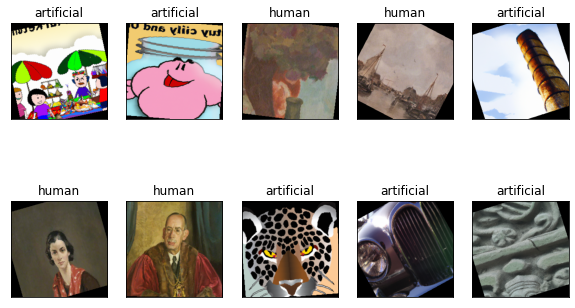

In [5]:
images, labels = next(iter(dataloader_train))
print(images.shape)
images = images.numpy()
fig = plt.figure(figsize=(10, 6))
batch_size = 10
class_names = dataset_train.classes
print("class_names: ", class_names)
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    image = images[idx]
    image = image.transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    ax.set_title("{}".format(class_names[labels[idx]]))

## Modeling

### Define model architecture

In [6]:
# Instantiate pre-trained resnet
model = torchvision.models.resnet18(pretrained=True)
# Shut off autograd for all layers to freeze model so the layer weights are not trained
for param in model.parameters():
    param.requires_grad = False

In [7]:
# Get the number of inputs to final Linear layer
num_features = model.fc.in_features

# Replace final Linear layer with a new Linear with the same number of inputs but just 2 outputs (2 classes)
model.fc = nn.Linear(num_features, 2)

In [8]:
# Summary of the model (after modification)
summary(model, (images.shape[1:]),batch_size=batch_size, device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [10, 64, 112, 112]           9,408
       BatchNorm2d-2         [10, 64, 112, 112]             128
              ReLU-3         [10, 64, 112, 112]               0
         MaxPool2d-4           [10, 64, 56, 56]               0
            Conv2d-5           [10, 64, 56, 56]          36,864
       BatchNorm2d-6           [10, 64, 56, 56]             128
              ReLU-7           [10, 64, 56, 56]               0
            Conv2d-8           [10, 64, 56, 56]          36,864
       BatchNorm2d-9           [10, 64, 56, 56]             128
             ReLU-10           [10, 64, 56, 56]               0
       BasicBlock-11           [10, 64, 56, 56]               0
           Conv2d-12           [10, 64, 56, 56]          36,864
      BatchNorm2d-13           [10, 64, 56, 56]             128
             ReLU-14           [10, 64,

### Define cost function and optimizer

In [9]:
# Cross entropy loss combines softmax and nn.NLLLoss() in one single class.
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

# Learning rate scheduler - decay LR by a factor of 0.1 every 8 epochs
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

### Training & Evaluation

In [10]:
# function for model training & evaluation
def train_model(model, criterion, optimizer, dataloaders, scheduler, device, num_epochs):
    model = model.to(device) # Send model to GPU if available
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Get the input images and labels, and send to GPU if available
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the weight gradients
                optimizer.zero_grad()

                # Forward pass to get outputs and calculate loss
                # Track gradient only for training data
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backpropagation to get the gradients with respect to each weight
                    # Only if in train
                    if phase == 'train':
                        loss.backward()
                        # Update the weights
                        optimizer.step()

                # Convert loss into a scalar and add it to running_loss
                running_loss += loss.item() * inputs.size(0)
                # Track number of correct predictions
                running_corrects += torch.sum(preds == labels.data)

            # Step along learning rate scheduler when in train
            if phase == 'train':
                scheduler.step()

            # Calculate and display average loss and accuracy for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # If model performs better on val set, save weights as the best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:3f}'.format(best_acc))

    # Load the weights from best model
    model.load_state_dict(best_model_wts)

    return model

In [11]:
# Train and save the model
model = train_model(model, criterion, optimizer, dataloaders, lr_scheduler, device, num_epochs=25)
torch.save(model.state_dict(), "models/model2.pth")

Epoch 1/25
----------
train Loss: 0.4366 Acc: 0.8160
val Loss: 0.2202 Acc: 0.9110

Epoch 2/25
----------
train Loss: 0.3065 Acc: 0.8623
val Loss: 0.1865 Acc: 0.9267

Epoch 3/25
----------
train Loss: 0.2539 Acc: 0.8905
val Loss: 0.1604 Acc: 0.9424

Epoch 4/25
----------
train Loss: 0.2437 Acc: 0.9018
val Loss: 0.1865 Acc: 0.9319

Epoch 5/25
----------
train Loss: 0.2295 Acc: 0.9086
val Loss: 0.1811 Acc: 0.9346

Epoch 6/25
----------
train Loss: 0.2665 Acc: 0.8849
val Loss: 0.1289 Acc: 0.9476

Epoch 7/25
----------
train Loss: 0.2023 Acc: 0.9266
val Loss: 0.1331 Acc: 0.9476

Epoch 8/25
----------
train Loss: 0.2074 Acc: 0.9165
val Loss: 0.1229 Acc: 0.9555

Epoch 9/25
----------
train Loss: 0.1805 Acc: 0.9244
val Loss: 0.1248 Acc: 0.9476

Epoch 10/25
----------
train Loss: 0.1715 Acc: 0.9266
val Loss: 0.1352 Acc: 0.9503

Epoch 11/25
----------
train Loss: 0.1782 Acc: 0.9289
val Loss: 0.1399 Acc: 0.9503

Epoch 12/25
----------
train Loss: 0.1761 Acc: 0.9391
val Loss: 0.1273 Acc: 0.9503

E

### Test

In [12]:
# load the existing model checkpoints
model.load_state_dict(torch.load("models/model2.pth"))

<All keys matched successfully>

In [13]:
model = model.to(device) # Send model to GPU if available
with torch.no_grad():
    model.eval()
    # Get all test images (every image in one batch)
    images, labels = next(iter(dataloader_test))
    images, labels = images.to(device), labels.to(device)
    # Get predictions
    _,preds = torch.max(model(images), 1)
    # convert predictions & labels to numpy array format
    y_pred = np.squeeze(preds.cpu().numpy())
    y_true = np.squeeze(labels.cpu().numpy())
class_names = dataset_test.classes
print("class_names: ", class_names)
print(y_pred)
print(y_true)

class_names:  ['artificial', 'human']
[1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0
 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 0 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1]
[1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 0 0 1 1 0 0 0 0
 0 0 1 1 1 0 1 0 0 0 1 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1
 1 1 0 1 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1]


In [14]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

  artificial       0.74      1.00      0.85        51
       human       1.00      0.65      0.79        52

    accuracy                           0.83       103
   macro avg       0.87      0.83      0.82       103
weighted avg       0.87      0.83      0.82       103



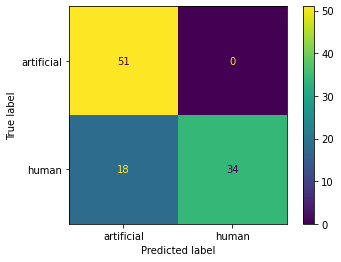

In [15]:
conf_mat = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=list(class_names))
disp.plot()
plt.show()

### Visualization

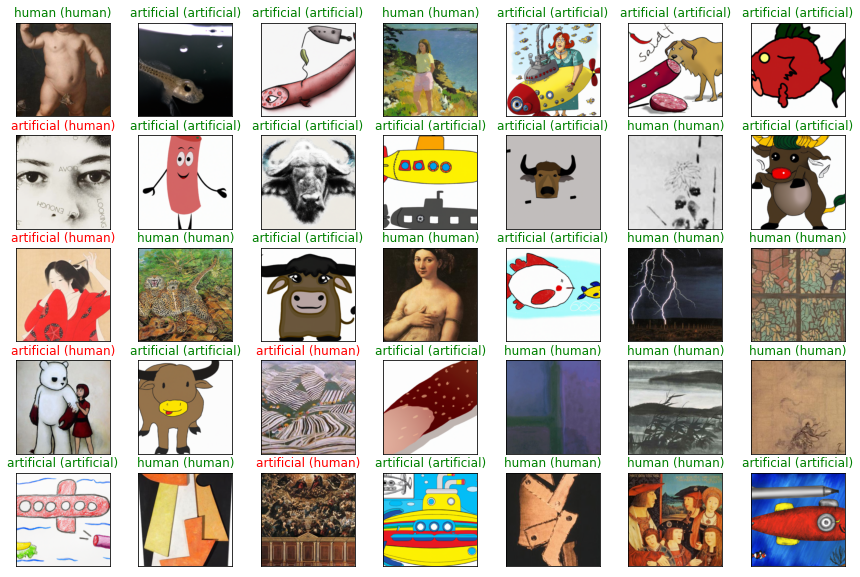

In [16]:
def visualize_results(model, dataloader, device):
    model = model.to(device) # Send model to GPU if available
    with torch.no_grad():
        model.eval()
        # Get a batch of validation images
        images, labels = next(iter(dataloader))
        images, labels = images.to(device), labels.to(device)
        # Get predictions
        _,preds = torch.max(model(images), 1)
        preds = np.squeeze(preds.cpu().numpy())
        images = images.cpu().numpy()

    # Plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(15, 10))
    for idx in np.arange(len(preds)):
        ax = fig.add_subplot(5, len(preds)//5, idx+1, xticks=[], yticks=[])
        image = images[idx]
        image = image.transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        ax.imshow(image)
        ax.set_title("{} ({})".format(class_names[preds[idx]], class_names[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx] else "red"))
    return

dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=35, shuffle=True, num_workers=4)
visualize_results(model, dataloader_test, device)